In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import norm
import seaborn as sns
sns.set_style("white")
import numpy as np 
import pandas as pd 
from scipy import stats, integrate
import matplotlib.transforms as mtransforms
from matplotlib import gridspec
import scipy.stats as st
from chapter_2_results.tools import Do_df_from_hdf

# Load data:

In [5]:
 head_filename_result_blocknonans =  'chapter_1_results/head_thorax_data_blk.h5' 
# Load list of bees
head_filename_result = 'chapter_1_results/head_thorax_data.h5'
flight_ids = pd.read_hdf(head_filename_result,key='flight_ids')

In [7]:
DF_traj=Do_df_from_hdf(head_filename_result_blocknonans, '/trajectories_filtered/flight_{}/blk_{}',part='head',flight_ids=flight_ids)
DF_error=Do_df_from_hdf(head_filename_result_blocknonans, '/errors_filtered/flight_{}/blk_{}',part='head',flight_ids=flight_ids)
DF_res_sac=Do_df_from_hdf(head_filename_result_blocknonans, '/res_sac/flight_{}/blk_{}',part='head',flight_ids=flight_ids)


# Error results visualization, all flights, inter and saccades

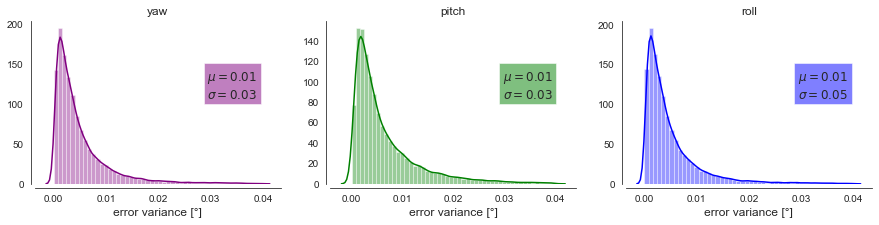

In [9]:
fig,axes=plt.subplots(1,3,figsize=(15,3))
angles=['alpha_0','alpha_1','alpha_2']
limit=0.04 ## to see something
for alpha_i,ax,color,name in zip (angles,axes.ravel(),['purple','green','blue'],['yaw','pitch','roll']):

    error=DF_error['zyx'].loc[:,[alpha_i]].loc[:,alpha_i].loc[:,alpha_i]
    error= np.rad2deg(error)
    error_crop=error[error<limit]
    sns.distplot(error_crop,color=color,ax=ax)
    mu=error.mean()
    std=error.std()
    lgd = ax.set_xlabel('error variance [°]', fontsize=12)
    
    ax.set_title(name)
    textstr = '\n'.join((r'$\mu=%.2f$' % (mu, ),r'$\sigma=%.2f$' % (std, )))
    x=0.7
    y=0.7
    props = dict(boxstyle='square', facecolor=color, alpha=0.5)
    ax.text(x,y,textstr, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
    sns.despine(offset=4)


# Significativity of the measure

To quantify if the measure is different from our error we used the z-score

The z score formula is 
$$\frac{measure-mean}{std}$$

I.e. We observe the value $m$ with an error $sigma$. We want to know the probability that we would have measure zero (perfect intersaccade)

In [10]:
#get saccade and intersaccade index
intersacc = DF_res_sac.saccade.isna()
intersacc_i = DF_res_sac.loc[DF_res_sac.intersac>=0].index
saccade_i = DF_res_sac.loc[DF_res_sac.saccade>=0].index

In [11]:
orient = DF_traj.zyx.copy()
orient['intersaccade'] = DF_res_sac.intersac


In [12]:
columns = ['alpha_0','alpha_1','alpha_2']

ind_inter=['flight_i','blk_i','intersac']

for name, group in DF_res_sac.groupby(ind_inter):

    circmean = st.circmean(orient.loc[group.index,columns], axis=0) ##average on the all intersaccade or saccade
    orient.loc[group.index,columns]-=circmean### remove circular mean
    

orient.loc[:,columns] = np.arctan2(np.sin(orient.loc[:,columns]),np.cos(orient.loc[:,columns]))


In [13]:
Errors=DF_error.zyx.loc[:,[('alpha_0','alpha_0'),('alpha_1','alpha_1'),('alpha_2','alpha_2')]]
Errors.columns=Errors.columns.droplevel(-1)

In [14]:
z_scores =  orient.loc[:,columns]
z_scores /=np.sqrt(Errors.loc[z_scores.index])## select index of only the intersaccades already

In [15]:
## get p-values of the z-score 
p_values = st.norm.sf(abs(z_scores)) #one-sided
p_values = pd.DataFrame(data=p_values,index=z_scores.index,columns=['alpha_0','alpha_1','alpha_2'])

# p-values flight by flight

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


53.57 percentage of significant measures for flight  05
52.11 percentage of significant measures for flight  06
59.49 percentage of significant measures for flight  07
56.35 percentage of significant measures for flight  08
67.43 percentage of significant measures for flight  11
59.75 percentage of significant measures for flight  17


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\ticker.py:1120: RuntimeWarning: divide by zero encountered in double_scalars
  coeff = np.round(x / b ** exponent)


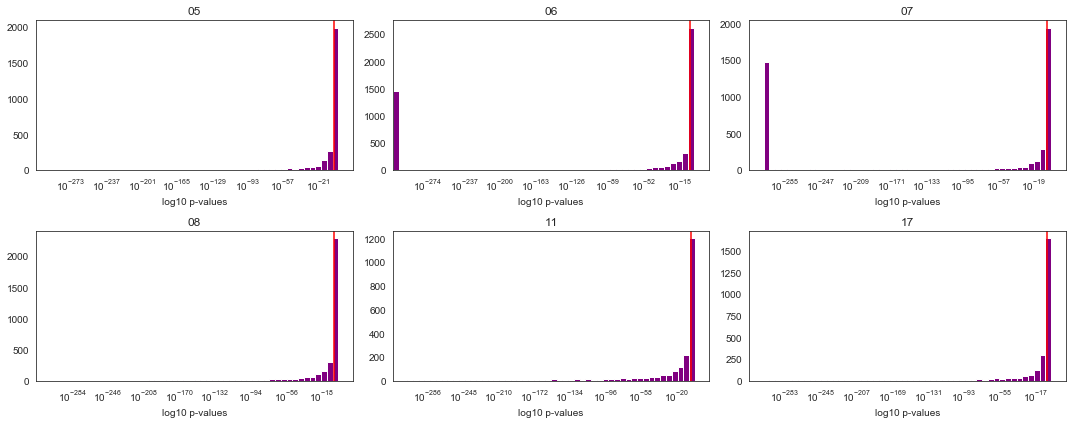

In [16]:
fig,axes=plt.subplots(2,3,figsize=(15,6))

for flight_id,ax in zip(flight_ids,axes.ravel()):
    
    alpha_i='alpha_0'
    
    p=p_values.xs((flight_id),level=('flight_i'))
    p=p.loc[:,alpha_i]

    p.loc[p==0] = p.loc[p>0].min()
    
    # Bonferroni
    threshold= 0.05/p.shape[0]

    overall_min = p.min()
    overall_max = p.max()
    
    binmin = np.log10(overall_min)
    binmax = np.log10(overall_max)
    
    nbbin = 51#????
    logbins = np.logspace(binmin,binmax,nbbin)
    
    ax.hist(p,bins=logbins, label='Intersaccade',color='purple')
    
    ax.set_title(flight_id)
    ax.axvline(threshold, color='r')
    ax.set_xscale('log')
    ax.set_xlabel('log10 p-values')
    print(np.round(p[p<threshold].shape[0]*100/p.shape[0],2),'percentage of significant measures for flight ',flight_id)
    
fig.tight_layout()

# p-values all flights

55.57 percentage of significant measures for all flights


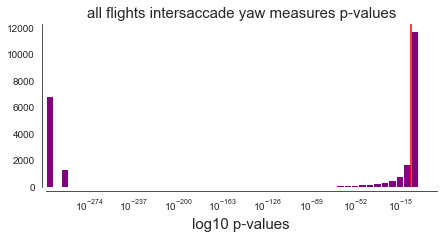

In [17]:
fig,ax=plt.subplots(1,1,figsize=(7,3))

alpha_i='alpha_0'

p=p_values.loc[:,alpha_i]

p.loc[p==0] = p.loc[p>0].min()

# Bonferroni
threshold= 0.05/p.shape[0]

overall_min = p.min()
overall_max = p.max()

binmin = np.log10(overall_min)
binmax = np.log10(overall_max)

nbbin = 51#????
logbins = np.logspace(binmin,binmax,nbbin)

ax.hist(p,bins=logbins, label='Intersaccade',color='purple')

ax.set_title('all flights intersaccade yaw measures p-values',fontsize=15)
ax.axvline(threshold, color='r')
ax.set_xscale('log')
ax.set_xlabel('log10 p-values',fontsize=15)
sns.despine(offset=4)
print(np.round(p[p<threshold].shape[0]*100/p.shape[0],2),'percentage of significant measures for all flights')
